<a href="https://colab.research.google.com/github/Veynitha/Y4S1_DL/blob/main/IT21298394.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW

In [110]:
# Install Kaggle and download dataset
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Automobile Insurance dataset from Kaggle
!kaggle datasets download -d aashishjhamtani/automobile-insurance

# Unzip the downloaded dataset
!unzip automobile-insurance.zip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aashishjhamtani/automobile-insurance
License(s): unknown
automobile-insurance.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  automobile-insurance.zip
replace insurance_claims.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: insurance_claims.csv    
  inflating: insurance_data_set.csv  


In [111]:
# Load the dataset
df = pd.read_csv('/content/insurance_claims.csv')

# Check the first few rows of the dataset
print(df.head())

# Get summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())


   months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount injury_claim  \
0       466132  ...      

In [112]:
# Drop irrelevant columns
df = df.drop(columns=['policy_number', 'policy_bind_date', 'insured_zip', '_c39', 'incident_location'])

# Check the updated dataset structure
print(df.info())

# Check the column names of the dataset
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_csl                   1000 non-null   object 
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

In [113]:
# Create a copy of the dataframe to avoid changes to the original
df_copy = df.copy()

# Convert 'incident_date' to datetime and extract features from it
df_copy['incident_date'] = pd.to_datetime(df_copy['incident_date'])
df_copy['incident_year'] = df_copy['incident_date'].dt.year
df_copy['incident_month'] = df_copy['incident_date'].dt.month
df_copy['incident_day'] = df_copy['incident_date'].dt.day
df_copy['incident_day_of_week'] = df_copy['incident_date'].dt.dayofweek
df_copy = df_copy.drop(columns=['incident_date'])

# Encode categorical features using LabelEncoder
labelencoder = LabelEncoder()

categorical_cols = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
                    'insured_occupation', 'insured_hobbies', 'insured_relationship',
                    'incident_type', 'collision_type', 'incident_severity',
                    'authorities_contacted', 'incident_state', 'incident_city',
                    'property_damage', 'police_report_available', 'auto_make', 'auto_model']

for col in categorical_cols:
    df_copy[col] = labelencoder.fit_transform(df_copy[col].astype(str))

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
                  'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
                  'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim']
df_copy[numerical_cols] = scaler.fit_transform(df_copy[numerical_cols])

# Check the updated DataFrame after encoding and scaling
print(df_copy.head())


   months_as_customer       age  policy_state  policy_csl  policy_deductable  \
0                 328  0.990836             2           1          -0.222383   
1                 228  0.334073             1           1           1.412784   
2                 134 -1.088913             2           0           1.412784   
3                 256  0.224613             0           1           1.412784   
4                 228  0.552994             0           2          -0.222383   

   policy_annual_premium  umbrella_limit  insured_sex  \
0               0.616705       -0.479476            1   
1              -0.242521        1.697980            1   
2               0.642233        1.697980            0   
3               0.652886        2.133471            0   
4               1.341980        2.133471            1   

   insured_education_level  insured_occupation  ...  property_claim  \
0                        4                   2  ...        1.165505   
1                        4        

In [114]:
# Separate features (X) and target (y)
X = df_copy.drop(columns=['fraud_reported'])
y = df_copy['fraud_reported']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


# Convert target variable to binary
y_train = np.where(y_train == 'Y', 1, 0)
y_test = np.where(y_test == 'Y', 1, 0)

print("Unique values in y_train after conversion:", np.unique(y_train))
print("Unique values in y_test after conversion:", np.unique(y_test))


Training set shape: (800, 37), (800,)
Testing set shape: (200, 37), (200,)
Unique values in y_train after conversion: [0 1]
Unique values in y_test after conversion: [0 1]


In [115]:
# Apply SMOTE for oversampling and under-sampling for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, X_valid, y_train_resampled, y_valid = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

In [148]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 2}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0, 1: 2.0}


In [149]:
# Focal loss function
def focal_loss(gamma=2., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = - alpha_t * tf.keras.backend.pow((1 - p_t), gamma) * tf.keras.backend.log(p_t)
        return tf.keras.backend.mean(fl)
    return focal_loss_fixed

In [163]:
# Initialize a new model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Third hidden layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 128)                 │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 15,233 (59.50 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=30, batch_size=32, callbacks=[early_stopping], class_weight=class_weights_dict)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5069 - loss: 59.3456 - val_accuracy: 1.0000 - val_loss: 2.4838e-14
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4841 - loss: 33.1947 - val_accuracy: 0.0000e+00 - val_loss: 10.5753
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4804 - loss: 23.5069 - val_accuracy: 0.0000e+00 - val_loss: 6.5974
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4835 - loss: 13.1249 - val_accuracy: 0.0785 - val_loss: 4.7587
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 9.8970 - val_accuracy: 0.9738 - val_loss: 0.5368
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4655 - loss: 7.5680 - val_accuracy: 0.0000e+00 - val_loss: 1.4155
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4723 - loss: 5.1295 - val_accuracy: 0.0000e+00 - val_loss: 0.9803
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4677 - loss: 3.8351 - val_ac

In [165]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2505 - loss: 24.6054 
Test Accuracy: 0.28
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[  0 145]
 [  0  55]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       145
           1       0.28      1.00      0.43        55

    accuracy                           0.28       200
   macro avg       0.14      0.50      0.22       200
weighted avg       0.08      0.28      0.12       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


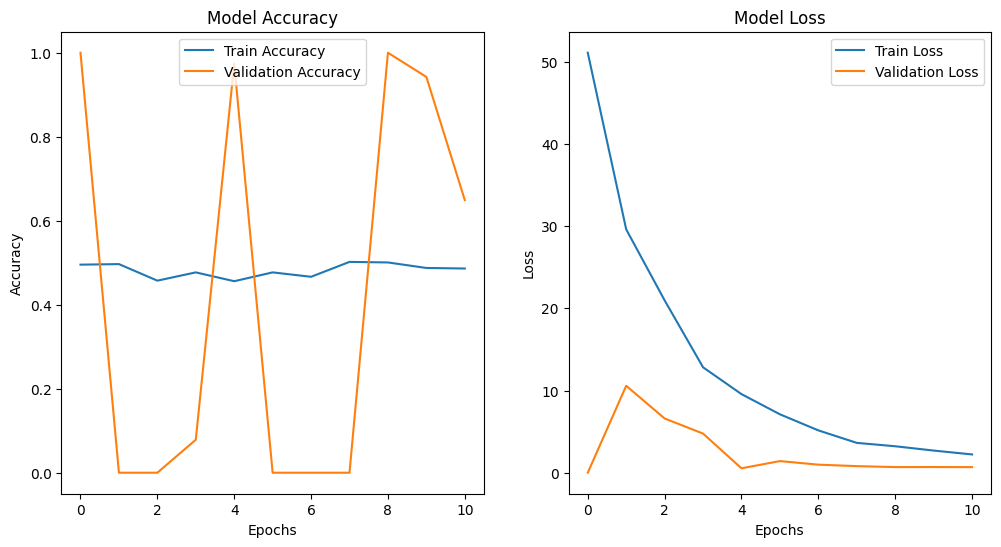

In [166]:
# Plot accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
